ctrl shift alt enter: debug

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def torch_fix_seed(seed=42):
    """ 乱数シードを固定
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

# 学習データセットの準備

In [22]:
# 初期条件: x∈[-1,0], y∈[-1,0], t=0のとき，u=-sin(x), v=-sin(y)
n_initial = 500
t_initial = np.zeros(n_initial) 
x_initial = (np.random.random(n_initial) - 0.5) * 2 
y_initial = (np.random.random(n_initial) - 0.5) * 2 

u_initial = np.ones(n_initial)
v_initial = np.ones(n_initial)
for i in range(n_initial):
    #if (x_initial[i]<0)&(y_initial[i]<0) :
    if 1==1:
        u_initial[i] = -0.5 * np.sin(np.pi * x_initial[i]) + 0.5
        v_initial[i] = -0.5 * np.sin(np.pi * y_initial[i]) + 0.5

# 境界条件: 壁面で(u, v)=(1, 1)
n_boundary = 250
t_boundary = np.random.random(n_boundary*2) *2
x_boundary_h = np.random.choice([-1, 1], n_boundary)
y_boundary_h = (np.random.random(n_boundary) - 0.5) * 2
x_boundary_v = (np.random.random(n_boundary) - 0.5) * 2
y_boundary_v = np.random.choice([-1, 1], n_boundary)
x_boundary = np.block([x_boundary_h, x_boundary_v])
y_boundary = np.block([y_boundary_h, y_boundary_v])
 
u_boundary = np.ones(n_boundary*2)*0.5
v_boundary = np.ones(n_boundary*2)*0.5

# 支配方程式の残差を評価する計算領域内の座標
n_region = 10000
t_region = np.random.random(n_region) *2
x_region = (np.random.random(n_region) - 0.5) * 2
y_region = (np.random.random(n_region) - 0.5) * 2 


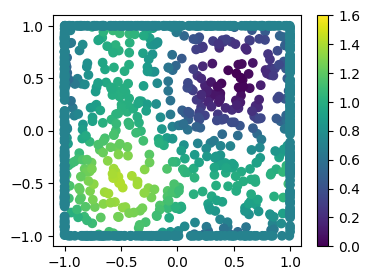

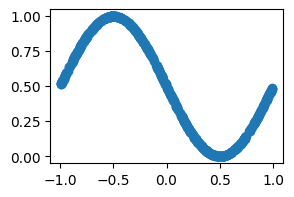

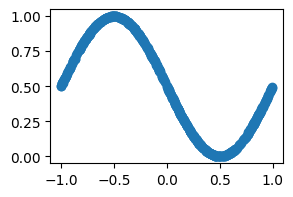

In [23]:
# 可視化
plt.figure(figsize=(4, 3))
plt.scatter(x_initial, y_initial, c=np.sqrt(u_initial**2+v_initial**2), vmin=0, vmax=1.6)
plt.scatter(x_boundary, y_boundary, c=np.sqrt(u_boundary**2+v_boundary**2), vmin=0, vmax=1.6)
plt.colorbar()
plt.show()

plt.figure(figsize=(3, 2))
plt.scatter(x_initial, u_initial)
plt.show()

plt.figure(figsize=(3, 2))
plt.scatter(y_initial, v_initial)
plt.show()

# ネットワークの構築

In [24]:
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hiddens=[32,64,128,128,64,32]):
        
        super(NN, self).__init__()
        
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(n_input, n_hiddens[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(n_hiddens[i], n_hiddens[i+1]) for i in range(len(n_hiddens)-1)]
        )
        self.output_layer = nn.Linear(n_hiddens[-1], n_output)
        
        
    def forward(self, x):
        
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        x = self.output_layer(x)
        
        return x

In [25]:
class BurgersPINN():
    def __init__(self, model, nu):
        """ 
        """
        self.model = model
        self.nu = nu
        
        
    def net_u(self, x, t):
        """ 物理量を出力
        """
        u = self.model(torch.cat([x, t], dim=1))
        return u


    def net_f(self, X, t):
        """ 支配方程式との残差を出力
        """    
        # モデルが予測する物理量
        U_pred = self.net_u(X, t)
        
        u = U_pred[:, [0]]
        v = U_pred[:, [1]]
        
        # 微分係数を逆伝搬で計算
        du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0].T[0]
        dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0].T[0]
        
        du_dx, du_dy = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0].T
        dv_dx, dv_dy = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0].T
        
        du_dxx, _ = torch.autograd.grad(du_dx, X, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0].T
        _, du_dyy = torch.autograd.grad(du_dy, X, grad_outputs=torch.ones_like(du_dy), retain_graph=True, create_graph=True)[0].T
        dv_dxx, _ = torch.autograd.grad(dv_dx, X, grad_outputs=torch.ones_like(dv_dx), retain_graph=True, create_graph=True)[0].T
        _, dv_dyy = torch.autograd.grad(dv_dy, X, grad_outputs=torch.ones_like(dv_dy), retain_graph=True, create_graph=True)[0].T
        
        # 支配方程式に代入(f=0だと方程式と完全一致)
        fx = du_dt + u.T * du_dx + v.T * du_dy - self.nu * (du_dxx + du_dyy)
        fy = dv_dt + u.T * dv_dx + v.T * dv_dy - self.nu * (dv_dxx + dv_dyy)
        
        return (fx + fy).T
    
    
    def fit(self, X_bc, Y_bc, X_region, max_epochs=300, learning_rate=0.01, pi_weight=5e-4):
        """ 学習データでモデルを訓練
        """
        # 入力データをスライス
        t = X_bc[:, [0]]
        x = X_bc[:, [1,2]]
        u = Y_bc 
        t_region = X_region[:, [0]] 
        x_region = X_region[:, [1,2]]
        
        # 入力をtorch.tensorに変換
        t = torch.tensor(t, requires_grad=True).float()
        x = torch.tensor(x, requires_grad=True).float()
        u = torch.tensor(u, requires_grad=True).float()
        x_region = torch.tensor(x_region, requires_grad=True).float()
        t_region = torch.tensor(t_region, requires_grad=True).float()
        
        # 最適化ロジック
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # モデルを学習モードに変更
        self.model.train()
        
        # 学習
        history = []
        for epoch in range(max_epochs+1):
            
            # 現在のモデルで予測
            u_pred = self.net_u(x, t)
            f_pred = self.net_f(x_region, t_region)
            
            # 損失を計算
            loss_u = torch.mean((u - u_pred)**2)
            loss_pi = torch.mean(f_pred**2)
            loss_total = loss_u + loss_pi * pi_weight
            
            # 誤差逆伝搬
            loss_total.backward()
            
            # 最適化ソルバーで重みを動かす
            optimizer.step()
            
            # 最適化ソルバーの勾配情報を初期化
            optimizer.zero_grad()
            
            if epoch % 10 == 0:
                print(f'epoch:{epoch}, loss:{loss_total.item()}, loss_u:{loss_u.item()}, loss_pi:{loss_pi.item()}')
            
                history.append([epoch, loss_total.item(), loss_u.item(), loss_pi.item()])
        
        return np.array(history)
                
    def predict(self, X_in):
        """ モデルの予測
        """
        t = X_in[:, [0]]
        x = X_in[:, [1,2]]
        
        # 入力をtorch.tensorに変換
        x = torch.tensor(x, requires_grad=True).float()
        t = torch.tensor(t, requires_grad=True).float()
        
        self.model.eval()  # 評価モードに変更

        u = self.net_u(x, t).detach().numpy()
        f = self.net_f(x, t).detach().numpy()
        
        return u, f

In [31]:
# 学習用のデータ
X_bc = np.block([[t_initial, t_boundary], [x_initial, x_boundary], [y_initial, y_boundary]]).T
Y_bc = np.block([[u_initial, u_boundary], [v_initial, v_boundary]]).T
X_region = np.block([[t_region], [x_region], [y_region]]).T

print("shape:", X_bc.shape, Y_bc.shape, X_region.shape)

model = NN(3, 2)
pinn_model = BurgersPINN(model, nu=0.1)

# モデルを学習
history = pinn_model.fit(X_bc, Y_bc, X_region, max_epochs=300, learning_rate=0.01, pi_weight=0.1)

shape: (1000, 3) (1000, 2) (10000, 3)
epoch:0, loss:0.4330832362174988, loss_u:0.43308311700820923, loss_pi:1.0749095054052304e-06
epoch:10, loss:0.07276128232479095, loss_u:0.07265380024909973, loss_pi:0.0010748552158474922
epoch:20, loss:0.04928150400519371, loss_u:0.044828325510025024, loss_pi:0.04453179985284805
epoch:30, loss:0.03795718401670456, loss_u:0.035851895809173584, loss_pi:0.021052895113825798
epoch:40, loss:0.026989152655005455, loss_u:0.02450963854789734, loss_pi:0.02479514665901661
epoch:50, loss:0.018532518297433853, loss_u:0.016161881387233734, loss_pi:0.023706363514065742
epoch:60, loss:0.013620493933558464, loss_u:0.011062576435506344, loss_pi:0.025579171255230904
epoch:70, loss:0.010635928250849247, loss_u:0.008613131009042263, loss_pi:0.02022796869277954
epoch:80, loss:0.008390570059418678, loss_u:0.006727711763232946, loss_pi:0.016628587618470192
epoch:90, loss:0.006853501312434673, loss_u:0.005405487958341837, loss_pi:0.014480131678283215
epoch:100, loss:0.005

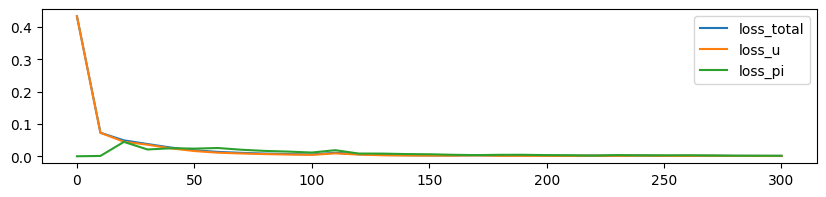

In [32]:
plt.figure(figsize=(10,2))
plt.plot(history[:, 0], history[:, 1], label='loss_total')
plt.plot(history[:, 0], history[:, 2], label='loss_u')
plt.plot(history[:, 0], history[:, 3], label='loss_pi')
plt.legend()

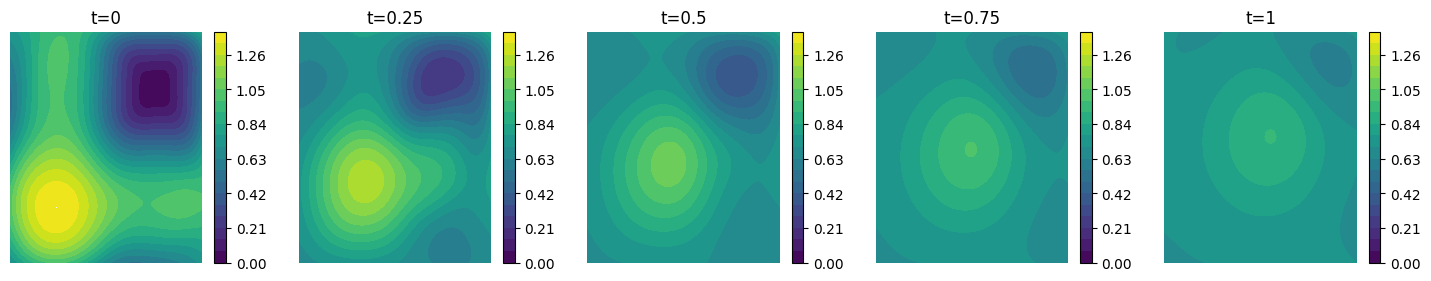

In [33]:
# 予測したいポイント
n = 100
x_pred = np.linspace(-1, 1, n)
y_pred = np.linspace(-1, 1, n)

x_grid, y_grid = np.meshgrid(x_pred, y_pred)

fig = plt.figure(figsize=(18, 3))

for i, t in enumerate([0, 0.25, 0.5, 0.75, 1]):
    t_pred = np.ones(n*n) * t
    X_in = np.block([[t_pred], [x_grid.flatten()], [y_grid.flatten()]]).T
    pred,_  = pinn_model.predict(X_in)

    u_pred = pred.reshape(n, n, 2)[:,:,0]
    v_pred = pred.reshape(n, n, 2)[:,:,1]

    # 物理量を可視化
    fig.add_subplot(1, 5, i+1)   
    plt.contourf(x_pred, y_pred, np.sqrt(u_pred**2+v_pred**2), np.linspace(0,1.4,21))
    plt.axis('off')
    plt.colorbar()
    plt.title(f't={t}')

plt.show()


In [34]:
np.max(np.sqrt(u_pred**2+v_pred**2))

0.91181713

In [37]:
from mpl_toolkits.mplot3d import Axes3D


for i, t in enumerate(np.arange(0, 2, 0.05)):
    t_pred = np.ones(n*n) * t
    X_in = np.block([[t_pred], [x_grid.flatten()], [y_grid.flatten()]]).T
    pred,_  = pinn_model.predict(X_in)

    u_pred = pred.reshape(n, n, 2)[:,:,0]
    v_pred = pred.reshape(n, n, 2)[:,:,1]

    # 物理量を可視化
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    z_grid = np.sqrt(u_pred**2+v_pred**2)
    ax.plot_surface(
        x_grid, y_grid, z_grid,
        edgecolor='royalblue', lw=0.5, rstride=4, cstride=4,
        alpha=0.2,
    )
    
    ax.contourf(x_grid, y_grid, z_grid, zdir='z', offset=-0.1, cmap='coolwarm', vmin=-0.1, vmax=1.6)
    #ax.contour(x_grid, y_grid, z_grid, zdir='x', offset=-1.1, cmap='coolwarm', vmin=-0.1, vmax=2.8)
    #ax.contour(x_grid, y_grid, z_grid, zdir='y', offset=1.1, cmap='coolwarm', vmin=-0.1, vmax=2.8)
    ax.set(
        xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), zlim=(-0.1, 1.3),
        xlabel='X', ylabel='Y', zlabel='Z'
    )
    ax.view_init(azim=-45)
    plt.savefig(f"anim/burgers_i_{i:03}.png")

/tmp/ipykernel_279793/3017378800.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


In [36]:
#ライブラリのインポート
from PIL import Image
#画像を入れる箱を準備
pictures=[]
#画像を箱に入れていく
for i in range(40):
    pic_name=f'anim/burgers_i_{i:03}.png'
    img = Image.open(pic_name)
    pictures.append(img)
#gifアニメを出力する
pictures[0].save('anime.gif',save_all=True, append_images=pictures[1:],  optimize=True, duration=300, loop=0)

In [12]:
times = [0, 0.25, 0.5, 0.75]

fig = plt.figure(figsize=(15, 2))

for i, t in enumerate(times):
    t_pred = np.ones([100, 1]) * t
    X_in = np.column_stack([x_pred, t_pred])
    u_pred, f_pred = pinn_model.predict(X_in)
    
    fig.add_subplot(1, 4, i+1)    
    plt.plot(x_pred, u_pred, label='u_pred')
    plt.plot(x_pred, f_pred, label='f_pred')
    plt.ylim(-1.5, 1.5)
    plt.legend()
plt.show()
    

IndexError: index 2 is out of bounds for axis 1 with size 2

<Figure size 1500x200 with 0 Axes>